In [11]:
import argparse
import itertools
import numpy as np
import pandas as pd

from rdkit import Chem, Geometry
from tqdm import tqdm
from rdkit.Chem import Draw
from pdb import set_trace


def get_exits(mol):
    """
    Returns atoms marked as exits in DeLinker data
    """
    exits = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol == '*':
            exits.append(atom)
    return exits


def set_anchor_flags(mol, anchor_idx):
    """
    Sets property _Anchor to all atoms in a molecule
    """
    for atom in mol.GetAtoms():
        if atom.GetIdx() == anchor_idx:
            atom.SetProp('_Anchor', '1')
        else:
            atom.SetProp('_Anchor', '0')


def get_anchors_idx(mol):
    anchors_idx = []
    for atom in mol.GetAtoms():
        if atom.GetProp('_Anchor') == '1':
            anchors_idx.append(atom.GetIdx())

    return anchors_idx


def update_fragment(frag):
    """
    Removes exit atoms with corresponding bonds and sets _Anchor property
    删除具有相应键的退出原子并设置 Anchor 属性
    
    """
    exits = get_exits(frag)
    if len(exits) > 1:
        raise Exception('Found more than one exits in fragment')
    exit = exits[0]

    bonds = exit.GetBonds()
    if len(bonds) > 1:
        raise Exception('Exit atom has more than 1 bond')
    bond = bonds[0]

    exit_idx = exit.GetIdx()
    source_idx = bond.GetBeginAtomIdx()
    target_idx = bond.GetEndAtomIdx()
    anchor_idx = source_idx if target_idx == exit_idx else target_idx
    set_anchor_flags(frag, anchor_idx)

    efragment = Chem.EditableMol(frag)
    efragment.RemoveBond(source_idx, target_idx)
    efragment.RemoveAtom(exit_idx)

    return efragment.GetMol()


def update_linker(linker):
    """
    Removes exit atoms with corresponding bonds
    """
    exits = get_exits(linker)
    if len(exits) > 2:
        raise Exception('Found more than two exits in linker')

    # Sort exit atoms by id for further correct deletion
    exits = sorted(exits, key=lambda e: e.GetIdx(), reverse=True)
    elinker = Chem.EditableMol(linker)

    # Remove exit bonds
    for exit in exits:
        bonds = exit.GetBonds()
        if len(bonds) > 1:
            raise Exception('Exit atom has more than 1 bond')
        bond = bonds[0]
        source_idx = bond.GetBeginAtomIdx()
        target_idx = bond.GetEndAtomIdx()
        elinker.RemoveBond(source_idx, target_idx)

    # Remove exit atoms
    for exit in exits:
        elinker.RemoveAtom(exit.GetIdx())

    return elinker.GetMol()


def create_conformer(coords):
    conformer = Chem.Conformer()
    for i, (x, y, z) in enumerate(coords):
        conformer.SetAtomPosition(i, Geometry.Point3D(x, y, z))
    return conformer


def transfer_conformers(frag, mol):
    """
    Computes coordinates from molecule to fragment (for all matchings)
    """
    matches = mol.GetSubstructMatches(frag)
    if len(matches) < 1:
        raise Exception('Could not find fragment or linker matches')

    match2conf = {}
    for match in matches:
        mol_coords = mol.GetConformer().GetPositions()
        frag_coords = mol_coords[np.array(match)]
        frag_conformer = create_conformer(frag_coords)
        match2conf[match] = frag_conformer
# 相当于利用匹配信息match从整个分子“mol”的坐标中提取出frag的坐标，再用frag的坐标创建frag的构象，然后再把构象添加进列表
    return match2conf


def find_non_intersecting_matches(matches1, matches2, matches3):
    """
    Checks all possible triplets and selects only non-intersecting matches
    """
    triplets = list(itertools.product(matches1, matches2, matches3))
    non_intersecting_matches = set()
    for m1, m2, m3 in triplets:
        m1m2 = set(m1) & set(m2)
        m1m3 = set(m1) & set(m3)
        m2m3 = set(m2) & set(m3)
        if len(m1m2 | m1m3 | m2m3) == 0:
            non_intersecting_matches.add((m1, m2, m3))
    return list(non_intersecting_matches)


def find_matches_with_linker_in_the_middle(non_intersecting_matches, mol):
    """
    Selects only matches where linker is between fragments
    I.e. each fragment should have one atom that is included in the set of neighbors of all linker atoms
    """
    matches_with_linker_in_the_middle = []
    for m1, m2, lm in non_intersecting_matches:
        neighbors = set()
        for atom_idx in lm:
            atom_neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
            for neighbor in atom_neighbors:
                neighbors.add(neighbor.GetIdx())

        conn1 = set(m1) & neighbors
        conn2 = set(m2) & neighbors
        if len(conn1) == 1 and len(conn2) == 1:
            matches_with_linker_in_the_middle.append((m1, m2, lm))

    return matches_with_linker_in_the_middle


def find_correct_matches(matches_frag1, matches_frag2, matches_linker, mol):
    """
    Finds all correct fragments and linker matches
    """
    non_intersecting_matches = find_non_intersecting_matches(matches_frag1, matches_frag2, matches_linker)
    if len(non_intersecting_matches) == 1:
        return non_intersecting_matches

    return find_matches_with_linker_in_the_middle(non_intersecting_matches, mol)


def prepare_fragments_and_linker(frags_smi, linker_smi, mol):
    """
    Given a molecule and SMILES string of fragments from DeLinker data,
    creates fragment and linker conformers according to the molecule conformer,
    removes exit atoms and sets _Anchor property to all fragment atoms
    """

    frag1_smi, frag2_smi = frags_smi.split('.')
    frag1 = Chem.MolFromSmiles(frag1_smi)
    frag2 = Chem.MolFromSmiles(frag2_smi)
    linker = Chem.MolFromSmiles(linker_smi)
    img = Draw.MolToImage(frag1, frag2, linker, size=(300, 300), wedgeBonds=True, kekulize=True, showAtomNumbers=True)
    img.show()
    newfrag1 = update_fragment(frag1)
    newfrag2 = update_fragment(frag2)
    newlinker = update_linker(linker)

    match2conf_frag1 = transfer_conformers(newfrag1, mol)
    match2conf_frag2 = transfer_conformers(newfrag2, mol)
    match2conf_linker = transfer_conformers(newlinker, mol)

    correct_matches = find_correct_matches(
        match2conf_frag1.keys(),
        match2conf_frag2.keys(),
        match2conf_linker.keys(),
        mol,
    )

    # Expecting to see either a single correct match or two correct matches
    # If the molecule is symmetric then both matches are equivalent, and we can use any
    if len(correct_matches) > 2:
        raise Exception('Found more than two fragment matches')

    conf_frag1 = match2conf_frag1[correct_matches[0][0]]
    conf_frag2 = match2conf_frag2[correct_matches[0][1]]
    conf_linker = match2conf_linker[correct_matches[0][2]]
    newfrag1.AddConformer(conf_frag1)
    newfrag2.AddConformer(conf_frag2)
    newlinker.AddConformer(conf_linker)
# 相当于用坐标生成构象之后把构象信息添加进可编辑的分子中
    return newfrag1, newfrag2, newlinker
  
frags_smi = "*C(C)c1cn(C)nc1C.*c1cc(OC)cc(OC)c1"
linker_smi = "*C#SC*"
mol = "CC1=NC(CC2=NN=C(CCC(=O)NC3=CC=CC=C3)O2)=CS1"
try:
    frag1, frag2, linker = prepare_fragments_and_linker(frags_smi, linker_smi, mol)
except Exception as e:
    print(f'{mol} | {linker_smi} | {frags_smi} : {e}')

frag1, frag2, linker

CC1=NC(CC2=NN=C(CCC(=O)NC3=CC=CC=C3)O2)=CS1 | *C#SC* | *C(C)c1cn(C)nc1C.*c1cc(OC)cc(OC)c1 : MolToImage() got multiple values for argument 'size'


[19:37:14] SMILES Parse Error: syntax error while parsing: 
[19:37:14] SMILES Parse Error: Failed parsing SMILES ' ' for input: ' '


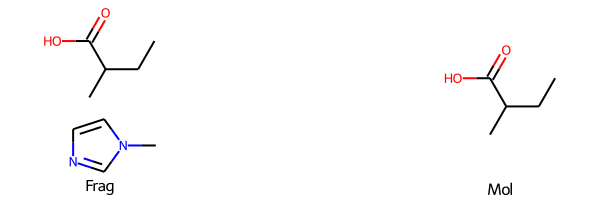

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

# 输入分子
frag = Chem.MolFromSmiles("CCC(C)C(=O)O.Cn1ccnc1")
link = Chem.MolFromSmiles(" ")
mol = Chem.MolFromSmiles("CCC(C)C(O)=O")

# 将分子存储在列表中
molecules = [frag, link, mol]

# 使用MolsToGridImage函数可视化多个分子
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(200, 200), legends=["Frag", "Link", "Mol"])
img

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

checkpoint = os.path.join('model')
model_list = os.listdir(checkpoint)
if len(model_list) > 0:
    last_model_files = os.path.join(checkpoint, model_list[-1])

epoch2fname = [
        (int(fname.split('=')[1].split('.')[0]), fname)
        for fname in os.listdir(last_model_files)
        if fname.endswith('.ckpt')
]
latest_fname = max(epoch2fname, key=lambda t: t[0])[1]
last_model = os.path.join(last_model_files, latest_fname)

print('=' * 30)
print(f'latest_fname {latest_fname}')
print(f'last_model {last_model}')
print('=' * 30)

last_model model/difflinker_test_louyl_zinc_difflinker_bs128_date18-10_time20-35-57.065690/difflinker_test_louyl_zinc_difflinker_bs128_date18-10_time20-35-57.065690_epoch=99.ckpt


In [7]:
import argparse
import os
import pwd
import sys
import yaml

from datetime import datetime
from pytorch_lightning import Trainer, callbacks, loggers

from src.const import NUMBER_OF_ATOM_TYPES, GEOM_NUMBER_OF_ATOM_TYPES
from src.lightning import DDPM
from src.utils import disable_rdkit_logging, Logger


resume = None
start_time = datetime.now().strftime('date%d-%m_time%H-%M-%S.%f')
run_name = f'{os.path.splitext('args.config')[0]}_{pwd.getpwuid(os.getuid())[0]}_{'args.exp_name'}_bs{'args.batch_size'}_{start_time}'
experiment = run_name if resume is None else resume
checkpoints_dir = os.path.join('args.checkpoints', experiment)
print(f'==========run name is {run_name}==========')
print(f'==========checkpoints dir is {checkpoints_dir}==========')

SyntaxError: f-string: unmatched '(' (3992278425.py, line 17)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd

sdf_supplier1 = Chem.SDMolSupplier("DiffLinker/sample/34/obabel/0_.sdf")
sdf_supplier2 = Chem.SDMolSupplier("DiffLinker/sample/36/obabel/0_.sdf")

# molecules = [mol for mol in sdf_supplier1]
molecules = [sdf_supplier1, sdf_supplier2]

img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200))
img


OSError: File error: Bad input file DiffLinker/sample/34/obabel/0_.sdf

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd

sdf_supplier1 = Chem.SDMolSupplier("DiffLinker/sample/34/obabel/0_.sdf")
sdf_supplier2 = Chem.SDMolSupplier("DiffLinker/sample/36/obabel/0_.sdf")

molecules1 = [mol for mol in sdf_supplier1 if mol is not None]
molecules2 = [mol for mol in sdf_supplier2 if mol is not None]

img1 = Draw.MolsToGridImage(molecules1, molsPerRow=4, subImgSize=(200, 200))
img2 = Draw.MolsToGridImage(molecules2, molsPerRow=4, subImgSize=(200, 200))

img1
img2

In [25]:
import argparse
import itertools
import numpy as np
import pandas as pd

from rdkit import Chem, Geometry
from tqdm import tqdm

from rdkit.Chem import Draw
from PIL import Image
from pdb import set_trace


def get_exits(mol):
    """
    Returns atoms marked as exits in DeLinker data
    """
    exits = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol == '*':
            exits.append(atom)
    return exits


def set_anchor_flags(mol, anchor_idx):
    """
    Sets property _Anchor to all atoms in a molecule
    """
    for atom in mol.GetAtoms():
        if atom.GetIdx() == anchor_idx:
            atom.SetProp('_Anchor', '1')
        else:
            atom.SetProp('_Anchor', '0')


def get_anchors_idx(mol):
    anchors_idx = []
    for atom in mol.GetAtoms():
        if atom.GetProp('_Anchor') == '1':
            anchors_idx.append(atom.GetIdx())

    return anchors_idx


def update_fragment(frag):
    """
    Removes exit atoms with corresponding bonds and sets _Anchor property
    删除具有相应键的退出原子并设置 Anchor 属性
    
    """
    exits = get_exits(frag)
    if len(exits) > 1:
        raise Exception('Found more than one exits in fragment')
    exit = exits[0]

    bonds = exit.GetBonds()
    if len(bonds) > 1:
        raise Exception('Exit atom has more than 1 bond')
    bond = bonds[0]

    exit_idx = exit.GetIdx()
    source_idx = bond.GetBeginAtomIdx()
    target_idx = bond.GetEndAtomIdx()
    anchor_idx = source_idx if target_idx == exit_idx else target_idx
    set_anchor_flags(frag, anchor_idx)

    efragment = Chem.EditableMol(frag)
    efragment.RemoveBond(source_idx, target_idx)
    efragment.RemoveAtom(exit_idx)

    return efragment.GetMol()


def update_linker(linker):
    """
    Removes exit atoms with corresponding bonds
    """
    exits = get_exits(linker)
    if len(exits) > 2:
        raise Exception('Found more than two exits in linker')

    # Sort exit atoms by id for further correct deletion
    exits = sorted(exits, key=lambda e: e.GetIdx(), reverse=True)
    elinker = Chem.EditableMol(linker)

    # Remove exit bonds
    for exit in exits:
        bonds = exit.GetBonds()
        if len(bonds) > 1:
            raise Exception('Exit atom has more than 1 bond')
        bond = bonds[0]
        source_idx = bond.GetBeginAtomIdx()
        target_idx = bond.GetEndAtomIdx()
        elinker.RemoveBond(source_idx, target_idx)

    # Remove exit atoms
    for exit in exits:
        elinker.RemoveAtom(exit.GetIdx())

    return elinker.GetMol()


def create_conformer(coords):
    conformer = Chem.Conformer()
    for i, (x, y, z) in enumerate(coords):
        conformer.SetAtomPosition(i, Geometry.Point3D(x, y, z))
    return conformer


def transfer_conformers(frag, mol):
    """
    Computes coordinates from molecule to fragment (for all matchings)
    """
    matches = mol.GetSubstructMatches(frag)
    if len(matches) < 1:
        raise Exception('Could not find fragment or linker matches')

    match2conf = {}
    for match in matches:
        mol_coords = mol.GetConformer().GetPositions()
        frag_coords = mol_coords[np.array(match)]
        frag_conformer = create_conformer(frag_coords)
        match2conf[match] = frag_conformer
# 相当于利用匹配信息match从整个分子“mol”的坐标中提取出frag的坐标，再用frag的坐标创建frag的构象，然后再把构象添加进列表
    return match2conf


def find_non_intersecting_matches(matches1, matches2, matches3):
    """
    Checks all possible triplets and selects only non-intersecting matches
    """
    triplets = list(itertools.product(matches1, matches2, matches3))
    non_intersecting_matches = set()
    for m1, m2, m3 in triplets:
        m1m2 = set(m1) & set(m2)
        m1m3 = set(m1) & set(m3)
        m2m3 = set(m2) & set(m3)
        if len(m1m2 | m1m3 | m2m3) == 0:
            non_intersecting_matches.add((m1, m2, m3))
    return list(non_intersecting_matches)


def find_matches_with_linker_in_the_middle(non_intersecting_matches, mol):
    """
    Selects only matches where linker is between fragments
    I.e. each fragment should have one atom that is included in the set of neighbors of all linker atoms
    """
    matches_with_linker_in_the_middle = []
    for m1, m2, lm in non_intersecting_matches:
        neighbors = set()
        for atom_idx in lm:
            atom_neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
            for neighbor in atom_neighbors:
                neighbors.add(neighbor.GetIdx())

        conn1 = set(m1) & neighbors
        conn2 = set(m2) & neighbors
        if len(conn1) == 1 and len(conn2) == 1:
            matches_with_linker_in_the_middle.append((m1, m2, lm))

    return matches_with_linker_in_the_middle


def find_correct_matches(matches_frag1, matches_frag2, matches_linker, mol):
    """
    Finds all correct fragments and linker matches
    """
    non_intersecting_matches = find_non_intersecting_matches(matches_frag1, matches_frag2, matches_linker)
    if len(non_intersecting_matches) == 1:
        return non_intersecting_matches

    return find_matches_with_linker_in_the_middle(non_intersecting_matches, mol)


def prepare_fragments_and_linker(frags_smi, linker_smi, mol):
    """
    Given a molecule and SMILES string of fragments from DeLinker data,
    creates fragment and linker conformers according to the molecule conformer,
    removes exit atoms and sets _Anchor property to all fragment atoms
    """
    # print(f'frags_smi = {frags_smi}')
    frag1_smi, frag2_smi = frags_smi.split('.')
    frag1 = Chem.MolFromSmiles(frag1_smi)
    frag2 = Chem.MolFromSmiles(frag2_smi)
    linker = Chem.MolFromSmiles(linker_smi)
    # print(frag1 is None)
    # print(f'frag1_smi, frag2_smi = {frag1_smi, frag2_smi}')
    
    newfrag1 = update_fragment(frag1)
    newfrag2 = update_fragment(frag2)
    newlinker = update_linker(linker)

    molecules = [newfrag1, newfrag2, newlinker]
    img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(200, 200), legends=["Frag1", "Frag2", "Link"])
    img.save("output.png")

    match2conf_frag1 = transfer_conformers(newfrag1, mol)
    match2conf_frag2 = transfer_conformers(newfrag2, mol)
    match2conf_linker = transfer_conformers(newlinker, mol)

    correct_matches = find_correct_matches(
        match2conf_frag1.keys(),
        match2conf_frag2.keys(),
        match2conf_linker.keys(),
        mol,
    )

    # Expecting to see either a single correct match or two correct matches
    # If the molecule is symmetric then both matches are equivalent, and we can use any
    if len(correct_matches) > 2:
        raise Exception('Found more than two fragment matches')

    conf_frag1 = match2conf_frag1[correct_matches[0][0]]
    conf_frag2 = match2conf_frag2[correct_matches[0][1]]
    conf_linker = match2conf_linker[correct_matches[0][2]]
    newfrag1.AddConformer(conf_frag1)
    newfrag2.AddConformer(conf_frag2)
    newlinker.AddConformer(conf_linker)
# 相当于用坐标生成构象之后把构象信息添加进可编辑的分子中
    return newfrag1, newfrag2, newlinker


def process_sdf(sdf_path, table, progress=True):
    supplier = Chem.SDMolSupplier(sdf_path)
    molecules = []
    fragments = []
    linkers = []
    out_table = []
    uuid = 0

    supplier = tqdm(supplier, total=len(supplier)) if progress else supplier
    for mol in supplier:
        # print(f'process_sdf:mol = {mol}')
        if mol is None:
            continue 
        mol_name = mol.GetProp('_Name')
        # mol_smi = Chem.MolToSmiles(mol)
        # mol.SetProp('_Name', mol_smi)
        # print(f'table.molecule = {table.molecule}')
        # print(f'mol_smi = {mol_smi}')
        # print(f'mol_name = {mol_name}')
        for linker_smi, frags_smi in table[table.molecule == mol_name][['linker', 'fragments']].values:
            # print(f'process_sdf:smi = {linker_smi, frags_smi}')
            try:
                frag1, frag2, linker = prepare_fragments_and_linker(frags_smi, linker_smi, mol)
            except Exception as e:
                print(f'{mol_name} | {linker_smi} | {frags_smi} : {e}')
                continue

            frags = Chem.CombineMols(frag1, frag2)
            anchors_idx = get_anchors_idx(frags)
            if len(anchors_idx) != 2:
                # print(f'{mol_name} | {linker_smi} | {frags_smi} : found {len(anchors_idx)} anchors')
                continue

            molecules.append(mol)
            fragments.append(frags)
            linkers.append(linker)
            out_table.append({
                'uuid': uuid,
                'molecule': mol_name,
                'fragments': Chem.MolToSmiles(frags),
                'linker': Chem.MolToSmiles(linker),
                'anchor_1': anchors_idx[0],
                'anchor_2': anchors_idx[1],
                # 'energy': mol.GetProp('_Energy'),
            })
            uuid += 1
            
        # print(f"out table attribute1: {len(molecules), len(fragments), len(linkers)}")
        # print(f"out table attribute2: {mol_name, anchors_idx[0], anchors_idx[1]}")

    return molecules, fragments, linkers, pd.DataFrame(out_table)

def run(table_smi, sdf_path, out_mol_path, out_frag_path, out_link_path, out_table_path, progress=True):
    # table = pd.read_csv(table_smi, sep=' ', names=['molecule', 'linker', 'fragments'])
    # table = pd.DataFrame({'molecule': table_smi[0], 'linker': table_smi[1], 'fragments': table_smi[2]})
    table_col = {}
    for i, column_name in enumerate(['molecule', 'linker', 'fragments']):
        # print(f"table_smi = {table_smi}")
        data_column = [row.split()[i] if i < len(row.split()) else None for row in table_smi]
        table_col[column_name] = data_column
        # print(f"sdf_path = {sdf_path}")
    # print(f"table_columns = {table_col}")
    table = pd.DataFrame(table_col)
    # print(f'table = {table}')
    molecules, fragments, linkers, out_table = process_sdf(sdf_path, table, progress)
    print(len(molecules))
    # print(f"out_table = {out_table}")
    # out_table.to_csv(out_table_path, index=False)
    out_table.to_csv(out_table_path, index=False, mode='w', header=False)
    with Chem.SDWriter(open(out_mol_path, 'w')) as writer:
        for mol in molecules:
            writer.write(mol)
    with Chem.SDWriter(open(out_frag_path, 'w')) as writer:
        writer.SetKekulize(False)
        for frags in fragments:
            writer.write(frags)
    with Chem.SDWriter(open(out_link_path, 'w')) as writer:
        writer.SetKekulize(False)
        for linker in linkers:
            writer.write(linker)


parser = argparse.ArgumentParser()
parser.add_argument('--table', action='store', type=str, default="DiffLinker/test.sdf")
parser.add_argument('--sdf', action='store', type=str, default="DiffLinker/test.smi")
parser.add_argument('--out_mol_sdf', action='store', type=str, default="out_mol_sdf1")
parser.add_argument('--out_frag_sdf', action='store', type=str, default="out_frag_sdf1")
parser.add_argument('--out_link_sdf', action='store', type=str, default="out_link_sdf1")
parser.add_argument('--out_table', action='store', type=str, default="out_table1")
args = parser.parse_args()

args.table
# run(
#     table_smi=args.table,
#     sdf_path=args.sdf,
#     out_mol_path=args.out_mol_sdf,
#     out_frag_path=args.out_frag_sdf,
#     out_link_path=args.out_link_sdf,
#     out_table_path=args.out_table,
# )


usage: ipykernel_launcher.py [-h] [--table TABLE] [--sdf SDF]
                             [--out_mol_sdf OUT_MOL_SDF]
                             [--out_frag_sdf OUT_FRAG_SDF]
                             [--out_link_sdf OUT_LINK_SDF]
                             [--out_table OUT_TABLE]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"d5cd417b-21f1-48f0-b010-afe41427ee8d" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/louyl/.local/share/jupyter/runtime/kernel-v2-1999148GoTDXgv7SfAF.json


SystemExit: 2

/home/louyl/anaconda3/envs/difflinker/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
